<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-Description" data-toc-modified-id="Data-Description-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data Description</a></span></li><li><span><a href="#Useful-Functions" data-toc-modified-id="Useful-Functions-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Useful Functions</a></span></li><li><span><a href="#Load-the-data" data-toc-modified-id="Load-the-data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Load the data</a></span></li><li><span><a href="#Modelling-Timeseries" data-toc-modified-id="Modelling-Timeseries-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Modelling Timeseries</a></span><ul class="toc-item"><li><span><a href="#Modelling:-ARIMA-for-non-seasonal-timeseries" data-toc-modified-id="Modelling:-ARIMA-for-non-seasonal-timeseries-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Modelling: ARIMA for non-seasonal timeseries</a></span></li><li><span><a href="#Find-Auto-Regressive-AR-term-p-(partial-correlation)" data-toc-modified-id="Find-Auto-Regressive-AR-term-p-(partial-correlation)-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Find Auto Regressive AR term p (partial correlation)</a></span></li><li><span><a href="#Find-Integrated-I-term-d-(differentiation-autocorrelation)" data-toc-modified-id="Find-Integrated-I-term-d-(differentiation-autocorrelation)-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Find Integrated I term d (differentiation autocorrelation)</a></span></li><li><span><a href="#Find-Moving-Average-MA-term-q" data-toc-modified-id="Find-Moving-Average-MA-term-q-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Find Moving Average MA term q</a></span></li><li><span><a href="#ARIMA-Modelling" data-toc-modified-id="ARIMA-Modelling-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>ARIMA Modelling</a></span></li><li><span><a href="#Model-Evaluation" data-toc-modified-id="Model-Evaluation-4.6"><span class="toc-item-num">4.6&nbsp;&nbsp;</span>Model Evaluation</a></span></li></ul></li><li><span><a href="#Auto-ARIMA" data-toc-modified-id="Auto-ARIMA-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Auto ARIMA</a></span><ul class="toc-item"><li><span><a href="#Interpret-the-residual-plots-in-ARIMA-model" data-toc-modified-id="Interpret-the-residual-plots-in-ARIMA-model-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Interpret the residual plots in ARIMA model</a></span></li><li><span><a href="#Future-Predictions" data-toc-modified-id="Future-Predictions-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Future Predictions</a></span></li></ul></li></ul></div>

# Data Description

Reference: https://www.kaggle.com/c/web-traffic-time-series-forecasting/data

```
Original data: train_1.csv
-----------------------------
rows = 145,063
columns = 551
first column = Page
date columns = 2015-07-01, 2015-07-02, ..., 2016-12-31 (550 columns)
file size: 284.6 MB


Data for time series
----------------------------------------------
selected year: 2016 (leap year 366 days)

selected time series:

The most visited page.
df['Page'] == """Special:Search_en.wikipedia.org_desktop_all-agents"""


```

**Notes**  
- This notebook used `pmdarima` and this pmd-arima module needs special statsmodels
  so, create a new conda env for this.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(color_codes=True)

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set(context='notebook', style='whitegrid', rc={'figure.figsize': (12,8)})
plt.style.use('fivethirtyeight') # better than sns styles.
matplotlib.rcParams['figure.figsize'] = 12,8

import os
import time

# random state
random_state=100
np.random.seed(random_state)

# Jupyter notebook settings for pandas
#pd.set_option('display.float_format', '{:,.2g}'.format) # numbers sep by comma
from pandas.api.types import CategoricalDtype
np.set_printoptions(precision=3)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100) # None for all the rows
pd.set_option('display.max_colwidth', 200)

import IPython
from IPython.display import display, HTML, Image, Markdown

import gc

import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.graphics.api as smg
import statsmodels.robust as smrb # smrb.mad() etc
import patsy # y,X1 = patsy.dmatrices(formula, df, return_type='dataframe') 

# versions
import watermark
%load_ext watermark
%watermark -a "Bhishan Poudel" -d -v -m
print()
%watermark -iv

Bhishan Poudel 2020-10-17 

CPython 3.7.9
IPython 7.18.1

compiler   : Clang 10.0.0 
system     : Darwin
release    : 19.6.0
machine    : x86_64
processor  : i386
CPU cores  : 4
interpreter: 64bit

numpy           1.19.2
statsmodels     0.12.0
seaborn         0.11.0
patsy           0.5.1
matplotlib      3.1.3
pandas          1.1.3
watermark       2.0.2
IPython         7.18.1
statsmodels.api 0.12.0



In [2]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

# Useful Functions

In [3]:
def show_methods(obj, ncols=4):
    lst = [i for i in dir(obj) if i[0]!='_' ]
    df = pd.DataFrame(np.array_split(lst,ncols)).T.fillna('')
    return df

MAPE - Mean Absolute Percentage Error:
$$
M A P E=\frac{100}{n} \sum_{i=1}^{n} \frac{\left|y_{i}-\hat{y}_{i}\right|}{y_{i}}
$$


SMAPE - Symmetric Mean Absolute Percentage Error:

$$
S M A P E=\frac{100 \%}{n} \sum_{t=1}^{n} \frac{\left|F_{t}-A_{t}\right|}{\left(\left|A_{t}\right|+\left|F_{t}\right|\right) / 2}
$$

In [4]:
def get_mape(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def get_smape(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred))
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0
    return 200 * np.mean(diff)

# Load the data

In [5]:
df = pd.read_csv('../data/train_1.csv.zip',compression='zip')

cond = df['Page'] == """Special:Search_en.wikipedia.org_desktop_all-agents"""
df = df.loc[cond]
df = df.filter(regex="Page|2016")
df = df.melt(id_vars=['Page'],var_name='date',value_name='visits').drop('Page',axis=1)
df = df.dropna(how='any')

print(df.shape)
df.iloc[:2,:5]

(366, 2)


,date,visits
0,2016-01-01,1401667.0
1,2016-01-02,1395136.0


In [6]:
df['date'] = pd.to_datetime(df['date'])
df['visits'] = df['visits'].astype(np.int32)
df = df[['visits','date']].set_index('date')

ts = df['visits']

ts.head()

date
2016-01-01    1401667
2016-01-02    1395136
2016-01-03    1455522
2016-01-04    1750373
2016-01-05    1787494
Name: visits, dtype: int32

In [7]:
# make sure this is series, not dataframe
type(ts)

pandas.core.series.Series

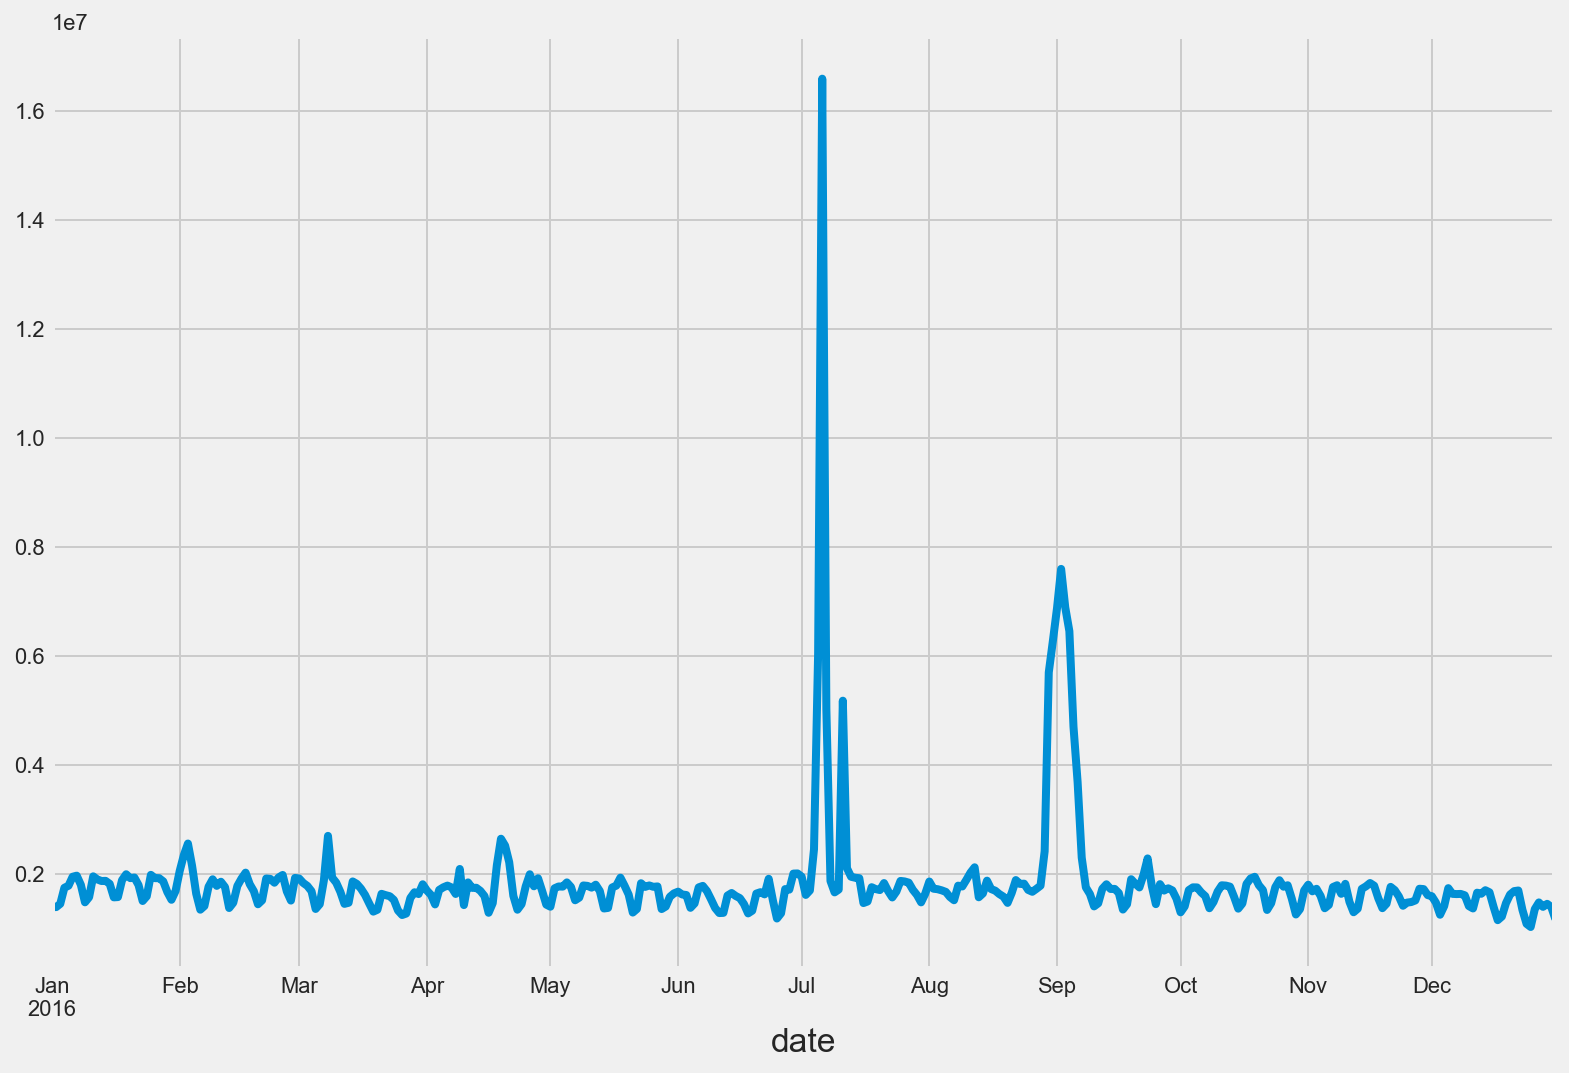

In [8]:
ts.plot()

In [9]:
# almost all values are around 0.2e7 except 3 peaks.
# these peaks will later harm timeseries modelling.

In [10]:
ts.describe().T

count    3.660000e+02
mean     1.845918e+06
std      1.095724e+06
min      1.030746e+06
25%      1.515952e+06
50%      1.700576e+06
75%      1.821304e+06
max      1.659208e+07
Name: visits, dtype: float64

In [11]:
t = ts[ts > 0.3e7]
t

date
2016-07-05     6038766
2016-07-06    16592075
2016-07-07     5025785
2016-07-11     5181746
2016-08-30     5700934
2016-08-31     6281005
2016-09-01     6878515
2016-09-02     7599524
2016-09-03     6894531
2016-09-04     6457072
2016-09-05     4705306
2016-09-06     3688959
Name: visits, dtype: int32

In [12]:
# the wikipedia page visits seems to have weekly periodicity
# we can try replacing these possible outlier values with value from one week
# prior to them.
#
# attempt2:
# we can also fill these values with mean from given week day.

In [13]:
idx = ts[ts > 0.3e7].index
idx

DatetimeIndex(['2016-07-05', '2016-07-06', '2016-07-07', '2016-07-11',
               '2016-08-30', '2016-08-31', '2016-09-01', '2016-09-02',
               '2016-09-03', '2016-09-04', '2016-09-05', '2016-09-06'],
              dtype='datetime64[ns]', name='date', freq=None)

In [14]:
idx - pd.Timedelta(days=7)

DatetimeIndex(['2016-06-28', '2016-06-29', '2016-06-30', '2016-07-04',
               '2016-08-23', '2016-08-24', '2016-08-25', '2016-08-26',
               '2016-08-27', '2016-08-28', '2016-08-29', '2016-08-30'],
              dtype='datetime64[ns]', name='date', freq=None)

In [15]:
ts[idx - pd.Timedelta(days=7)]

date
2016-06-28    1715507
2016-06-29    2010241
2016-06-30    2012923
2016-07-04    2457009
2016-08-23    1820624
2016-08-24    1825362
2016-08-25    1710625
2016-08-26    1676577
2016-08-27    1730368
2016-08-28    1788768
2016-08-29    2420356
2016-08-30    5700934
Name: visits, dtype: int32

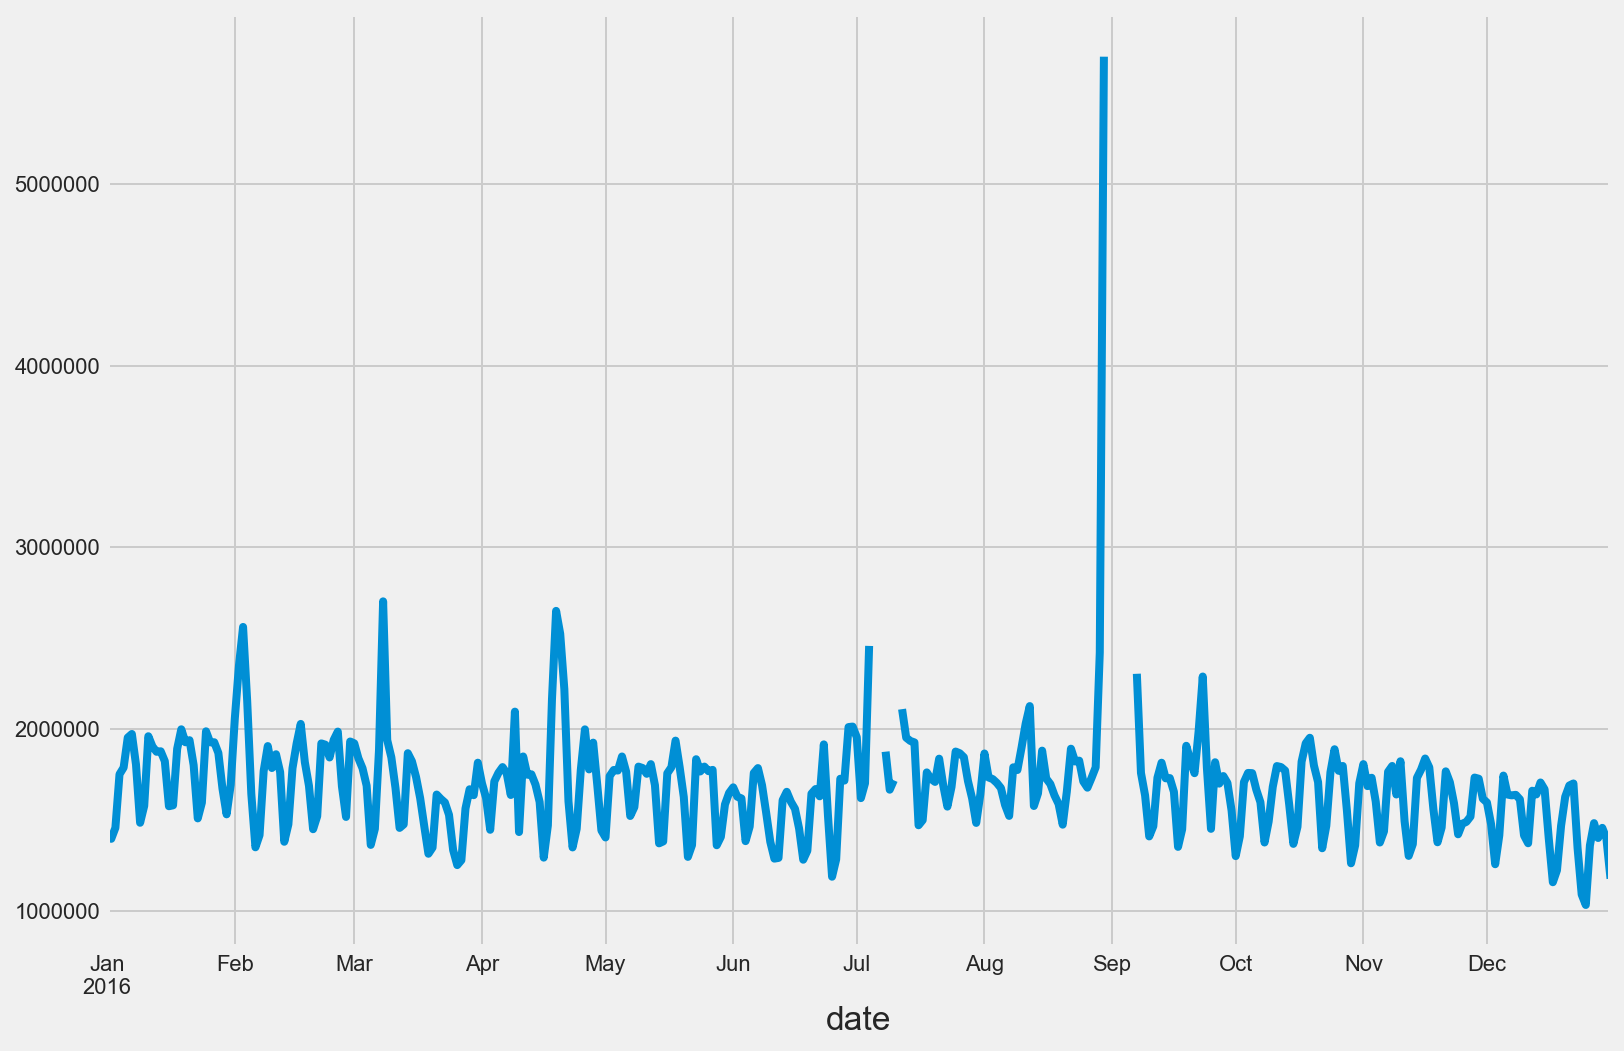

In [16]:
ts_no_outliers = ts.copy()
ts_no_outliers[idx] = ts_no_outliers[idx - pd.Timedelta(days=7)]

ts_no_outliers.plot()

In [17]:
# again i see only one peak, remove this peak
idx = ts[ts > 0.3e7].index
idx

DatetimeIndex(['2016-07-05', '2016-07-06', '2016-07-07', '2016-07-11',
               '2016-08-30', '2016-08-31', '2016-09-01', '2016-09-02',
               '2016-09-03', '2016-09-04', '2016-09-05', '2016-09-06'],
              dtype='datetime64[ns]', name='date', freq=None)

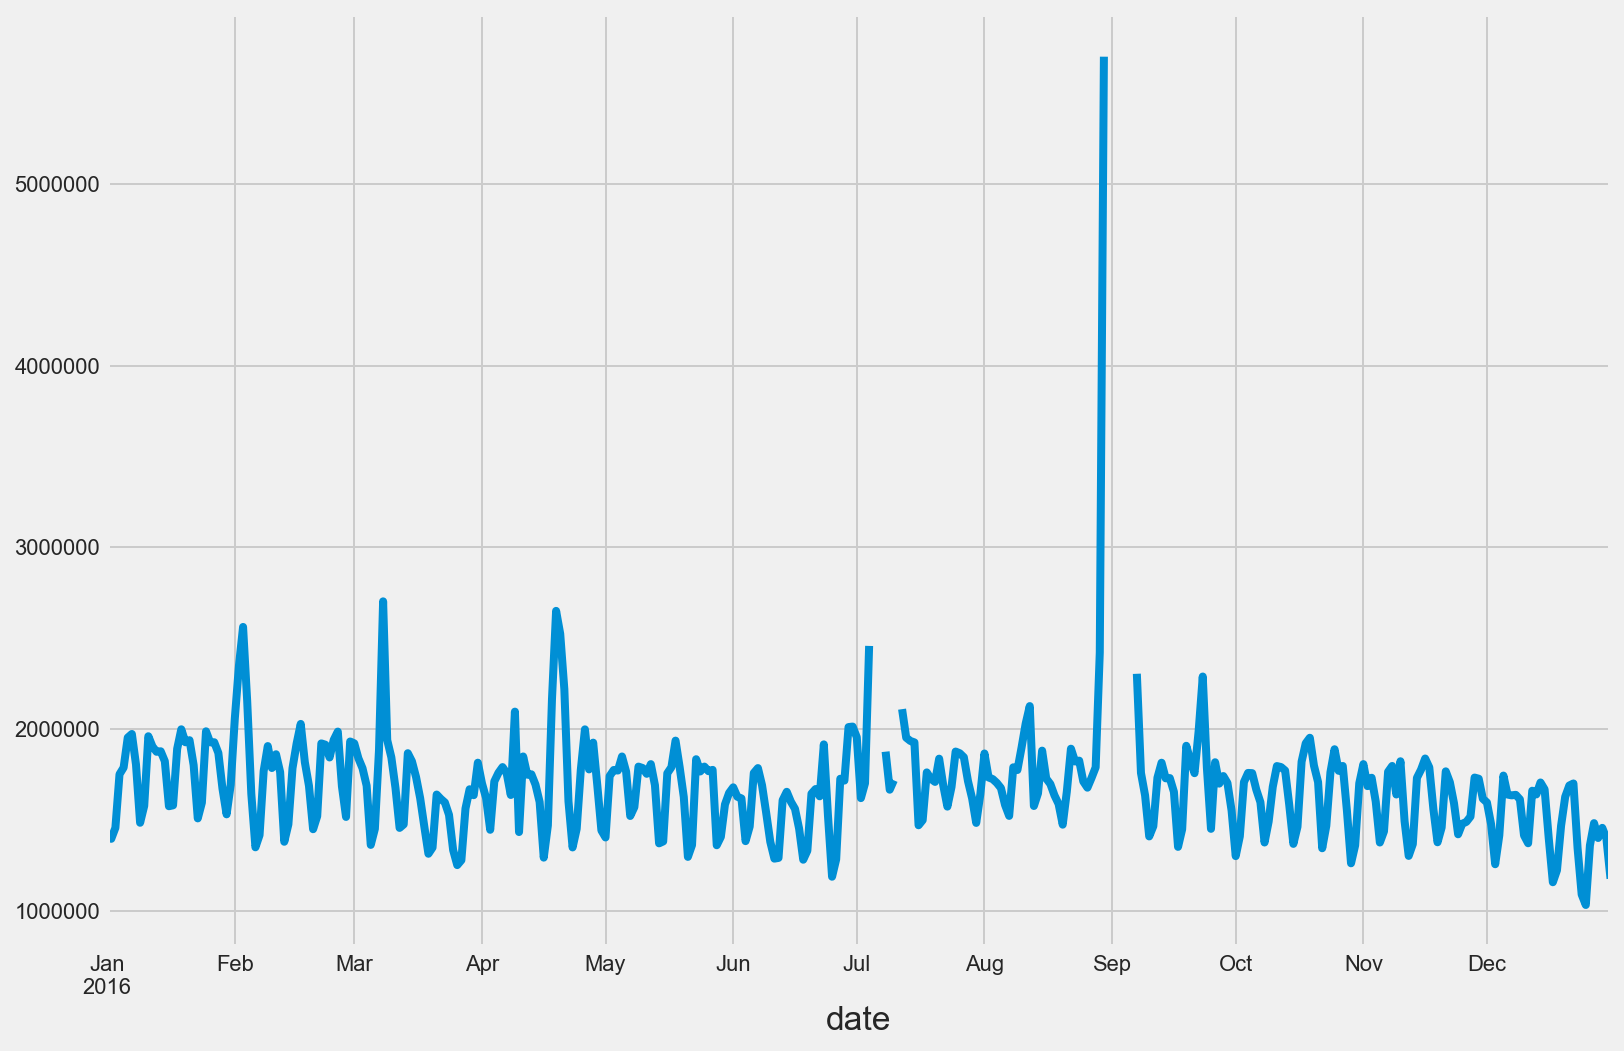

In [18]:
ts_no_outliers[idx] = ts_no_outliers[idx - pd.Timedelta(days=7)]

ts_no_outliers.plot()

In [19]:
ts_no_outliers.head().append(ts_no_outliers.tail())

date
2016-01-01    1401667.0
2016-01-02    1395136.0
2016-01-03    1455522.0
2016-01-04    1750373.0
2016-01-05    1787494.0
2016-12-27    1481319.0
2016-12-28    1399599.0
2016-12-29    1455447.0
2016-12-30    1397331.0
2016-12-31    1175657.0
Name: visits, dtype: float64

In [20]:
ts_no_outliers.shape

(366,)

In [21]:
# now try imputing outliers with given weekday mean.

In [22]:
ts[ts>0.3e7]

date
2016-07-05     6038766
2016-07-06    16592075
2016-07-07     5025785
2016-07-11     5181746
2016-08-30     5700934
2016-08-31     6281005
2016-09-01     6878515
2016-09-02     7599524
2016-09-03     6894531
2016-09-04     6457072
2016-09-05     4705306
2016-09-06     3688959
Name: visits, dtype: int32

In [23]:
ts_good_weekday_means = ts[ts<0.3e7].groupby(ts[ts<0.3e7].index.weekday).agg('mean')
ts_good_weekday_means

date
0    1.804507e+06
1    1.833039e+06
2    1.811539e+06
3    1.781031e+06
4    1.650711e+06
5    1.426800e+06
6    1.467813e+06
Name: visits, dtype: float64

In [24]:
ts_bad_idx_weekday = ts[ts>0.3e7].index.weekday
ts_bad_idx_weekday

Int64Index([1, 2, 3, 0, 1, 2, 3, 4, 5, 6, 0, 1], dtype='int64', name='date')

In [25]:
imputes = ts[ts>0.3e7].index.weekday.map(ts_good_weekday_means).to_numpy()
imputes

array([1833038.959, 1811539.16 , 1781030.9  , 1804507.3  , 1833038.959,
       1811539.16 , 1781030.9  , 1650711.058, 1426799.75 , 1467813.02 ,
       1804507.3  , 1833038.959])

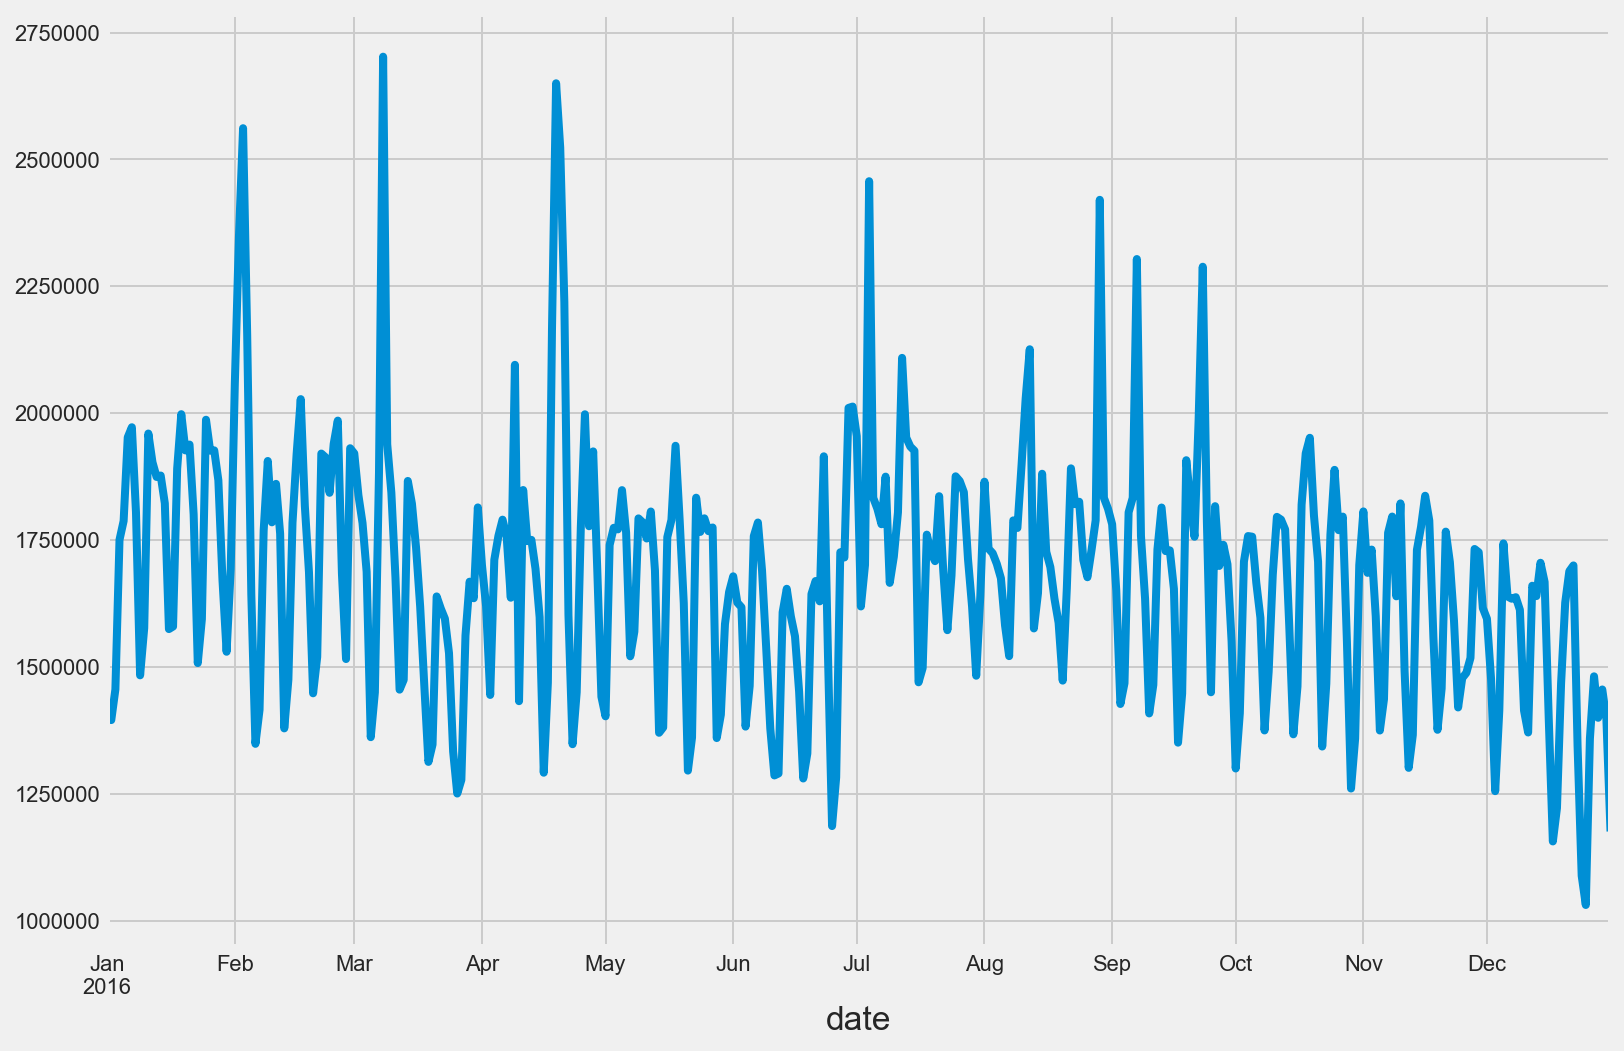

In [26]:
ts_no_outliers2 = ts.copy()
ts_no_outliers2[ts_no_outliers2>0.3e7] = imputes

ts_no_outliers2.plot()

# Modelling Timeseries

## Modelling: ARIMA for non-seasonal timeseries

ARIMA(pdq)

AR - auto regressive (p for past day effect)  
I - integrated (d for differencing)  
MA - moving averge (q for fluctuations errors)  


stationary = mean, variance does not change over time  

To make a timeseries stationary we can use differencing:
```
differencing: ydiff(t) = y(t) - y(t-1)
first order : ydiff1   = y(t) - y(t-1)
second order: ydiff2   = ydiff(t) - ydiff(t-1)
                       = [y(t) - y(t-1)] - [y(t-1) - y(t-2)]
                       = y(t) - 2y(t-1) + y(t-2)
```

Models:
```
T = trend 
C = cycle
S = seasonality
R = residual

Additive model: Y = T + C + S + R 
Multiplicative model: Y = T * C * S * R

```

References  
- [selecting p,d,q](https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/)

## Find Auto Regressive AR term p (partial correlation)
We can use Partial Autocorrelation (PACF) plot to estimate the autoregressive
term p.

In [27]:
def lag_plot_partial_autocorrelation():
    from statsmodels.graphics.tsaplots import plot_pacf

    for p in range(5):
        tsx = eval('ts' + '.diff()'*p + '.dropna()')
        fig = plot_pacf(tsx)
        plt.title(f'Partial Autocorrelation for lag p= {p}')
        plt.xticks(range(25))

# lag_plot_partial_autocorrelation()

# for 1st differencing p =1, most of the lines are almost inside 
# the significance limit.
# we can choose p = 1 to start with.

## Find Integrated I term d (differentiation autocorrelation)

In [28]:
def lag_plot_autocorrelation():
    from statsmodels.graphics.tsaplots import plot_acf

    for d in range(10):
        tsx = eval('ts' + '.diff()'*d + '.dropna()')
        fig = plot_acf(tsx)
        plt.title(f'Autocorrelation for lag d= {d}')
        plt.xticks(range(25))

# lag_plot_autocorrelation()

# I see that lag of d=7 gives similar lines above and below te base line.
# d=7, ie. weekly differencing is a good start.

In [29]:
# https://www.alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.ndiffs.html
import six
from pmdarima.arima.utils import ndiffs


## augmented DF Test
adf = ndiffs(ts, test='adf')

# KPSS test
kpss = ndiffs(ts, test='kpss')

# PP test:
pp = ndiffs(ts, test='pp')

adf, kpss, pp

(0, 0, 0)

In [30]:
# it shows that our time series is already stationary at no lagging.
# so, d =0 is a good start.

## Find Moving Average MA term q

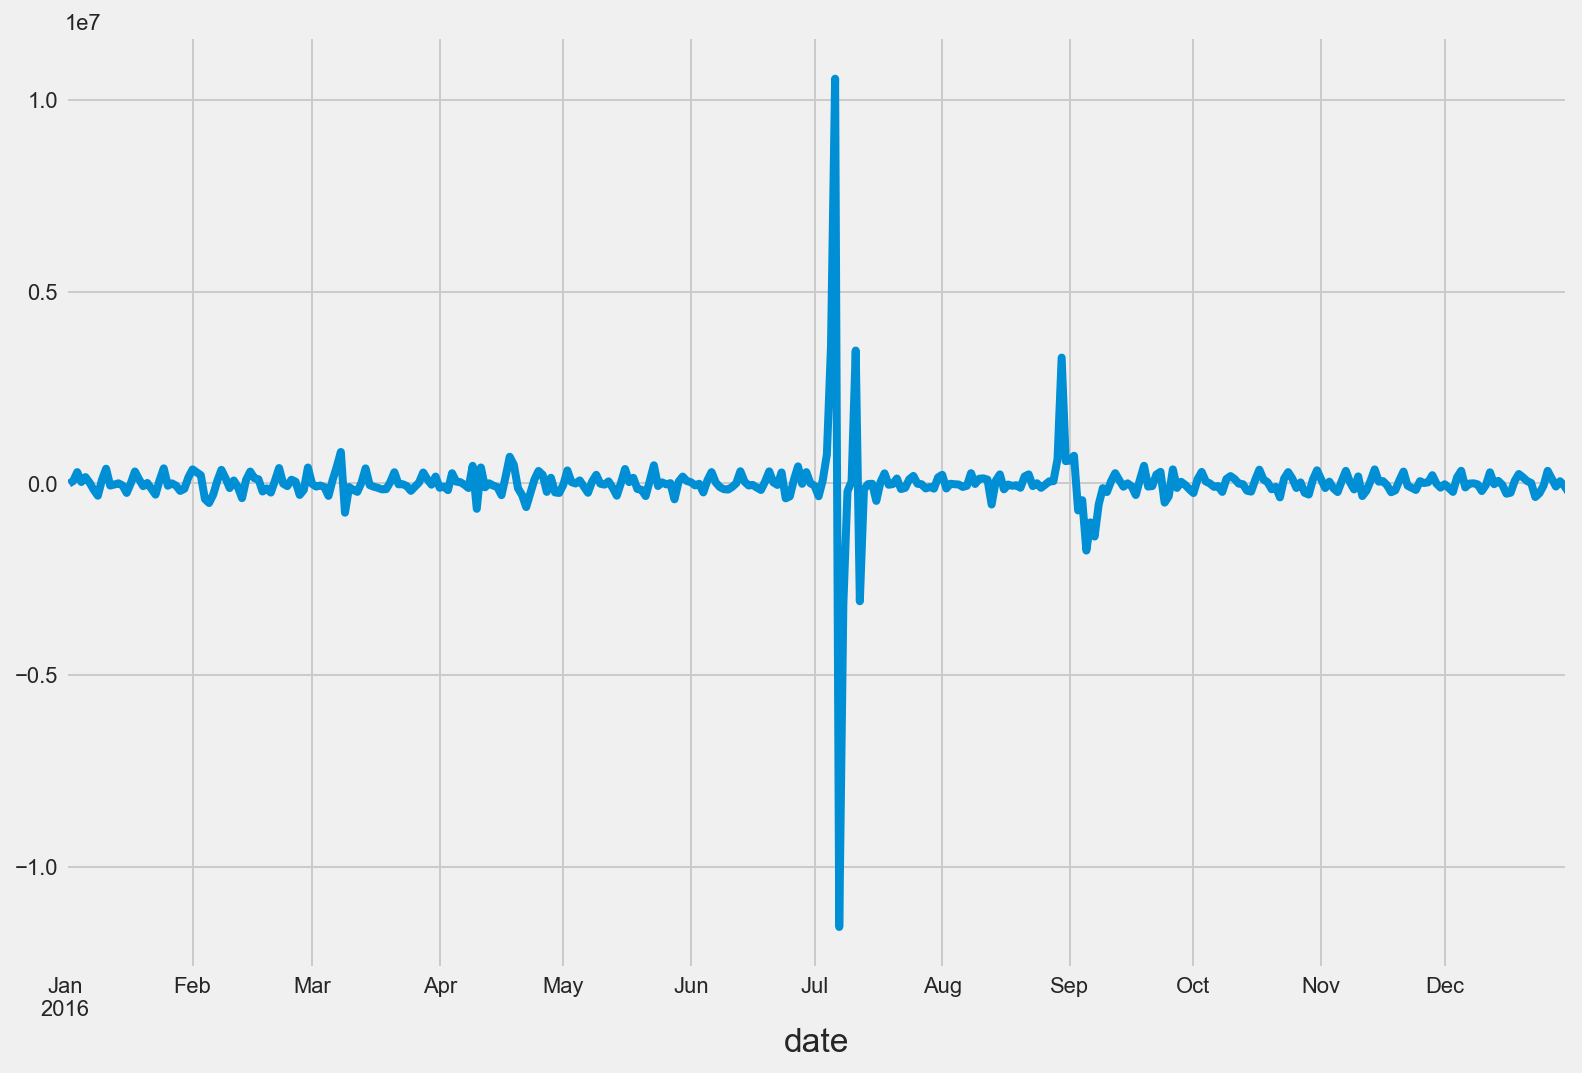

In [31]:
from statsmodels.graphics.tsaplots import plot_acf

ts.diff().plot()

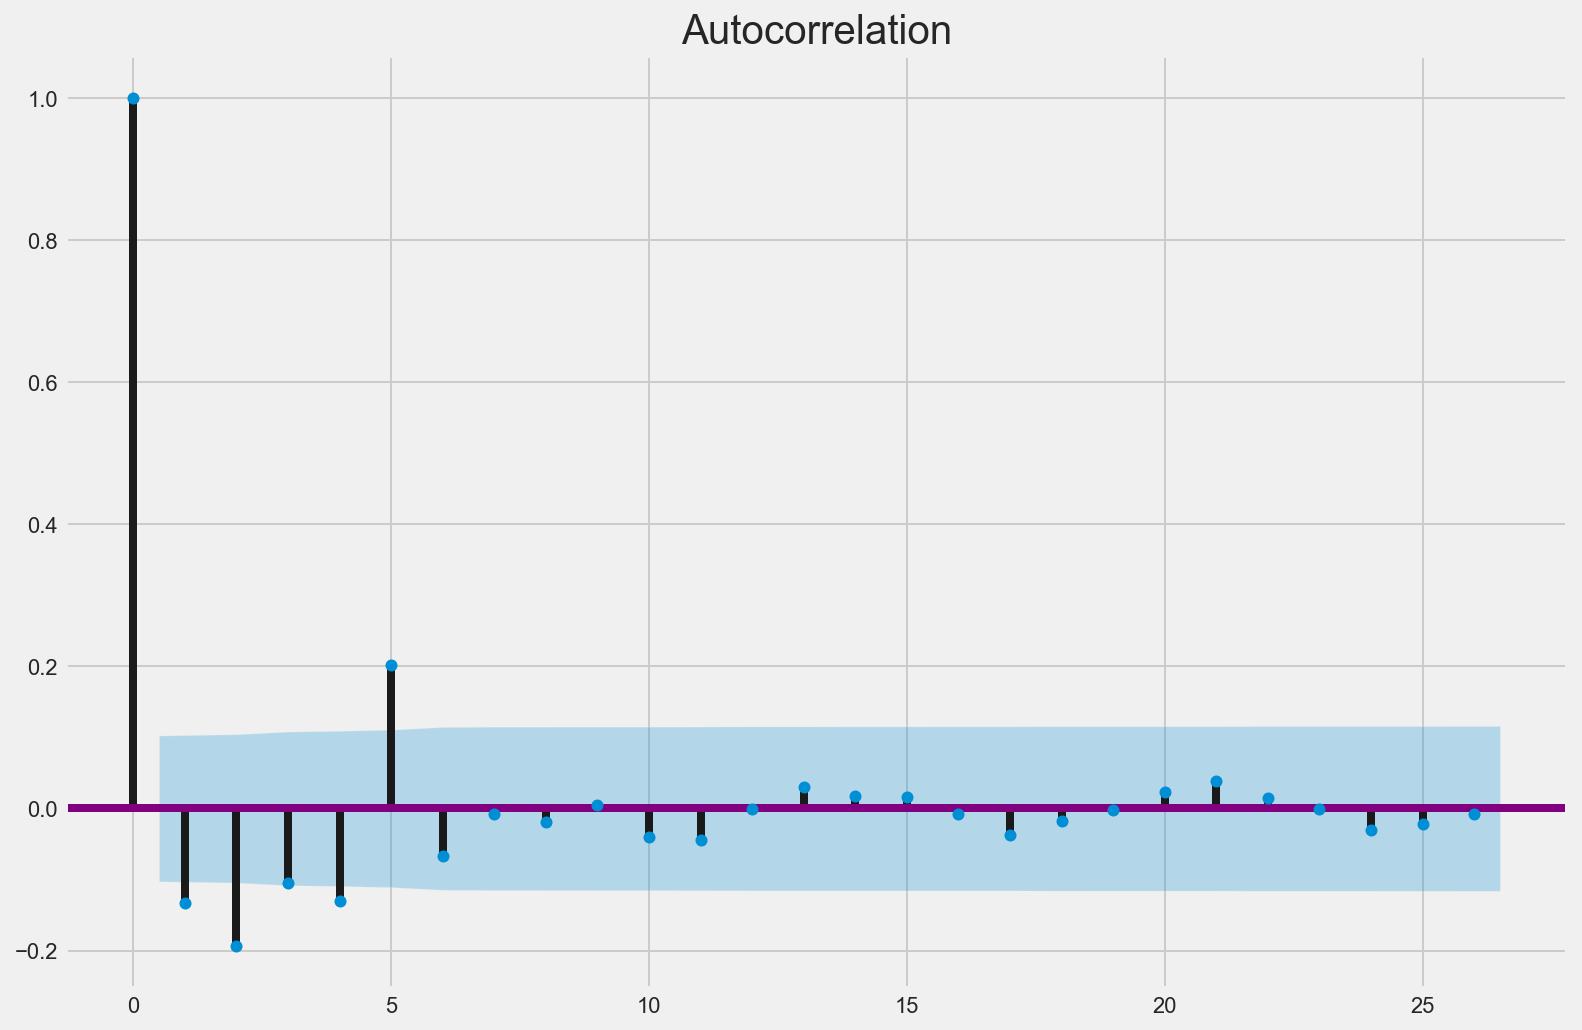

In [32]:
plot_acf(ts.diff().dropna());

In [33]:
# only few lags are above the significance region. so, choose q = 2.
# when in doubt choose simpler model.

## ARIMA Modelling

In [34]:
from statsmodels.tsa.arima_model import ARIMA

# 1,0,2 ARIMA Model
model = ARIMA(ts, order=(1,0,2))
model_fit = model.fit(disp=0)
model_fit.summary()

/Users/poudel/opt/miniconda3/envs/gam/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/poudel/opt/miniconda3/envs/gam/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency informa

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                 visits   No. Observations:                  366
Model:                     ARMA(1, 2)   Log Likelihood               -5515.184
Method:                       css-mle   S.D. of innovations         846735.155
Date:                Sat, 17 Oct 2020   AIC                          11040.367
Time:                        14:33:17   BIC                          11059.880
Sample:                    01-01-2016   HQIC                         11048.121
                         - 12-31-2016                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         1.846e+06   1.24e+05     14.854      0.000     1.6e+06    2.09e+06
ar.L1.visits     0.7185      0.115      6.267      0.000       0.494       0.943
ma.L1.visits    -0.0505      0.131     -0.385      0.700      -0.308       0.207
ma.L2.visits    -0.1547      0.111     -1.393      0.164      -0.372       0.063
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.3917           +0.0000j            1.3917            0.0000
MA.1            2.3843           +0.0000j            2.3843            0.0000
MA.2           -2.7104           +0.0000j            2.7104            0.5000
-----------------------------------------------------------------------------
"""

In [35]:
# here all coeffs are well above zero.
# if some coeffs were very close to zero, we could try reducing that lag.
#
# note that the p-value for ma L1 and L2 are greater than 0.05, they are
# not significant.
#
# try removing ma L2.

In [36]:
# 1,0,2 ARIMA Model
model = ARIMA(ts, order=(1,0,1))
model_fit = model.fit(disp=0)
model_fit.summary()

/Users/poudel/opt/miniconda3/envs/gam/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/poudel/opt/miniconda3/envs/gam/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency informa

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                 visits   No. Observations:                  366
Model:                     ARMA(1, 1)   Log Likelihood               -5515.882
Method:                       css-mle   S.D. of innovations         848375.072
Date:                Sat, 17 Oct 2020   AIC                          11039.764
Time:                        14:33:18   BIC                          11055.375
Sample:                    01-01-2016   HQIC                         11045.967
                         - 12-31-2016                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         1.846e+06   1.12e+05     16.541      0.000    1.63e+06    2.06e+06
ar.L1.visits     0.5585      0.071      7.858      0.000       0.419       0.698
ma.L1.visits     0.1153      0.087      1.318      0.187      -0.056       0.287
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.7906           +0.0000j            1.7906            0.0000
MA.1           -8.6752           +0.0000j            8.6752            0.5000
-----------------------------------------------------------------------------
"""

In [37]:
# again ma L1 lag p-value > 0.05

In [38]:
# 1,0,0 AR Model
model = ARIMA(ts, order=(1,0,0))
results_arima100 = model.fit(disp=0)
results_arima100.summary()

/Users/poudel/opt/miniconda3/envs/gam/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/poudel/opt/miniconda3/envs/gam/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency informa

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                 visits   No. Observations:                  366
Model:                     ARMA(1, 0)   Log Likelihood               -5516.733
Method:                       css-mle   S.D. of innovations         850362.651
Date:                Sat, 17 Oct 2020   AIC                          11039.467
Time:                        14:33:18   BIC                          11051.175
Sample:                    01-01-2016   HQIC                         11044.119
                         - 12-31-2016                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         1.846e+06   1.19e+05     15.516      0.000    1.61e+06    2.08e+06
ar.L1.visits     0.6281      0.041     15.499      0.000       0.549       0.708
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.5921           +0.0000j            1.5921            0.0000
-----------------------------------------------------------------------------
"""

In [39]:
# this looks like just an AR model without I and MA part.
# but still statsmodels calls it ARMA

show_methods(results_arima100)

,0,1,2,3
0,aic,fittedvalues,maroots,resid
1,arfreq,forecast,mle_retvals,save
2,arparams,hqic,mle_settings,scale
3,arroots,initialize,model,sigma2
4,bic,k_ar,n_totobs,summary
5,bse,k_constant,nobs,summary2
6,conf_int,k_exog,normalized_cov_params,t_test
7,cov_params,k_ma,params,t_test_pairwise
8,cov_params_default,k_trend,plot_predict,tvalues
9,data,llf,predict,use_t


## Model Evaluation

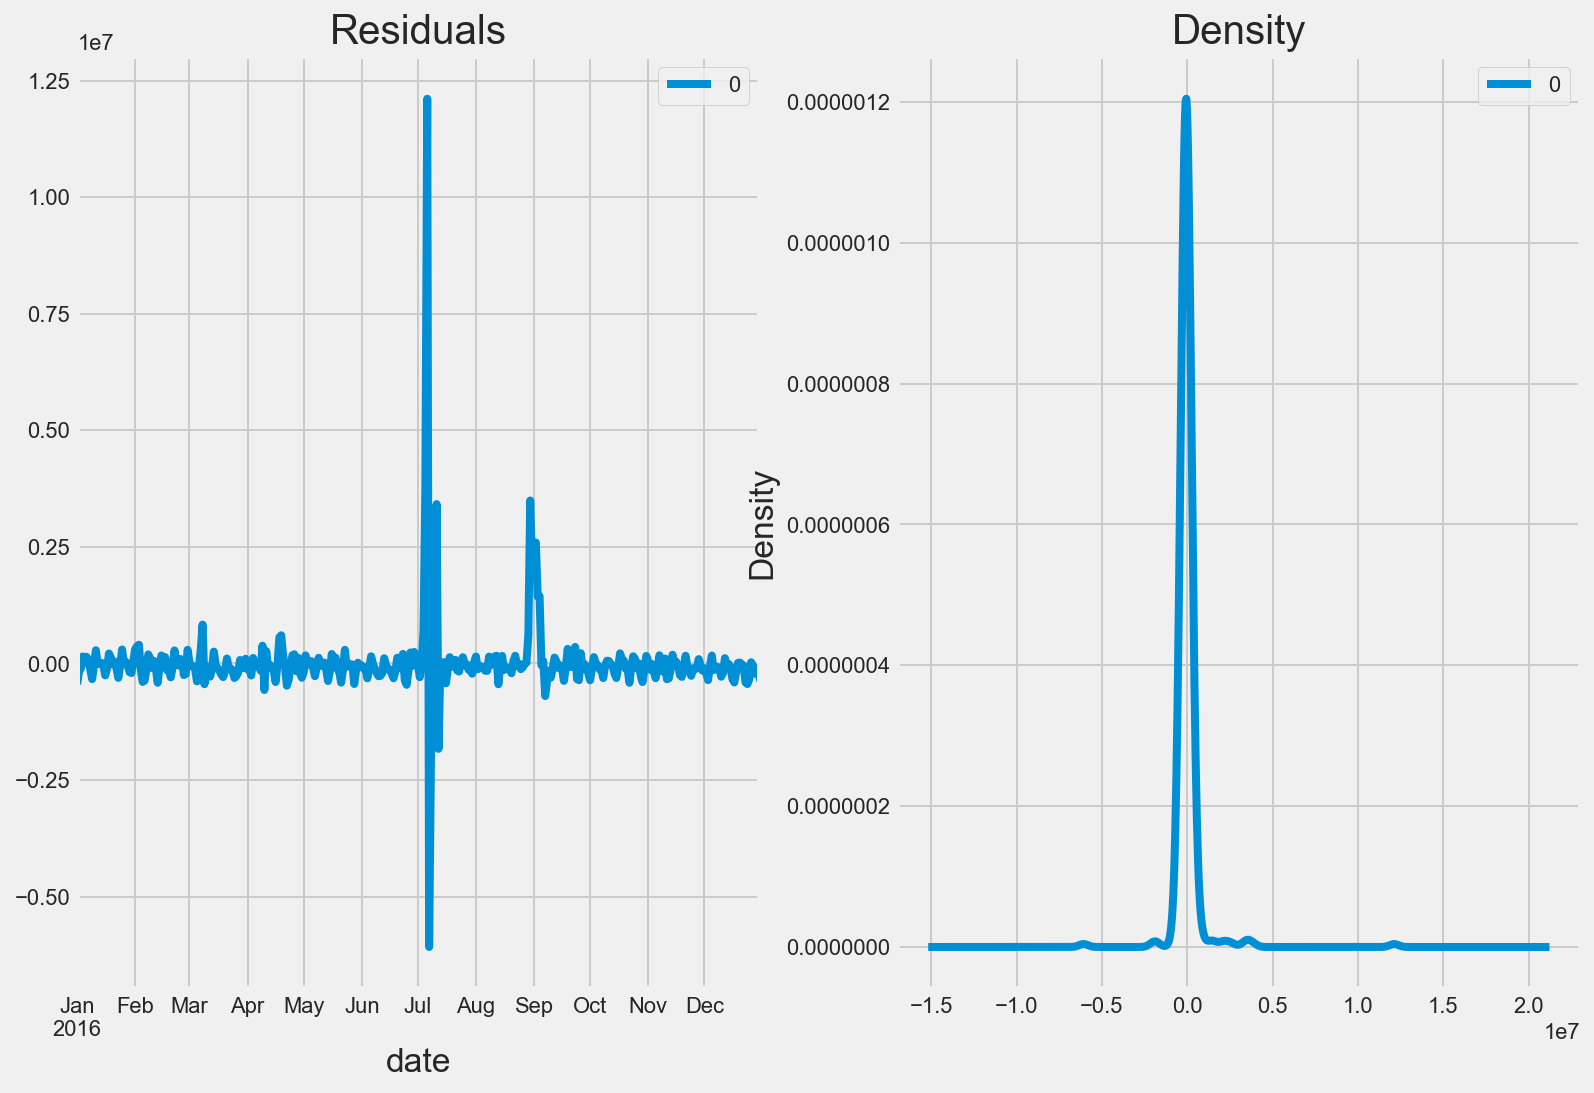

In [40]:
# Plot residual errors
residuals = pd.DataFrame(results_arima100.resid)
fig, ax = plt.subplots(1,2,figsize=(12,8))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

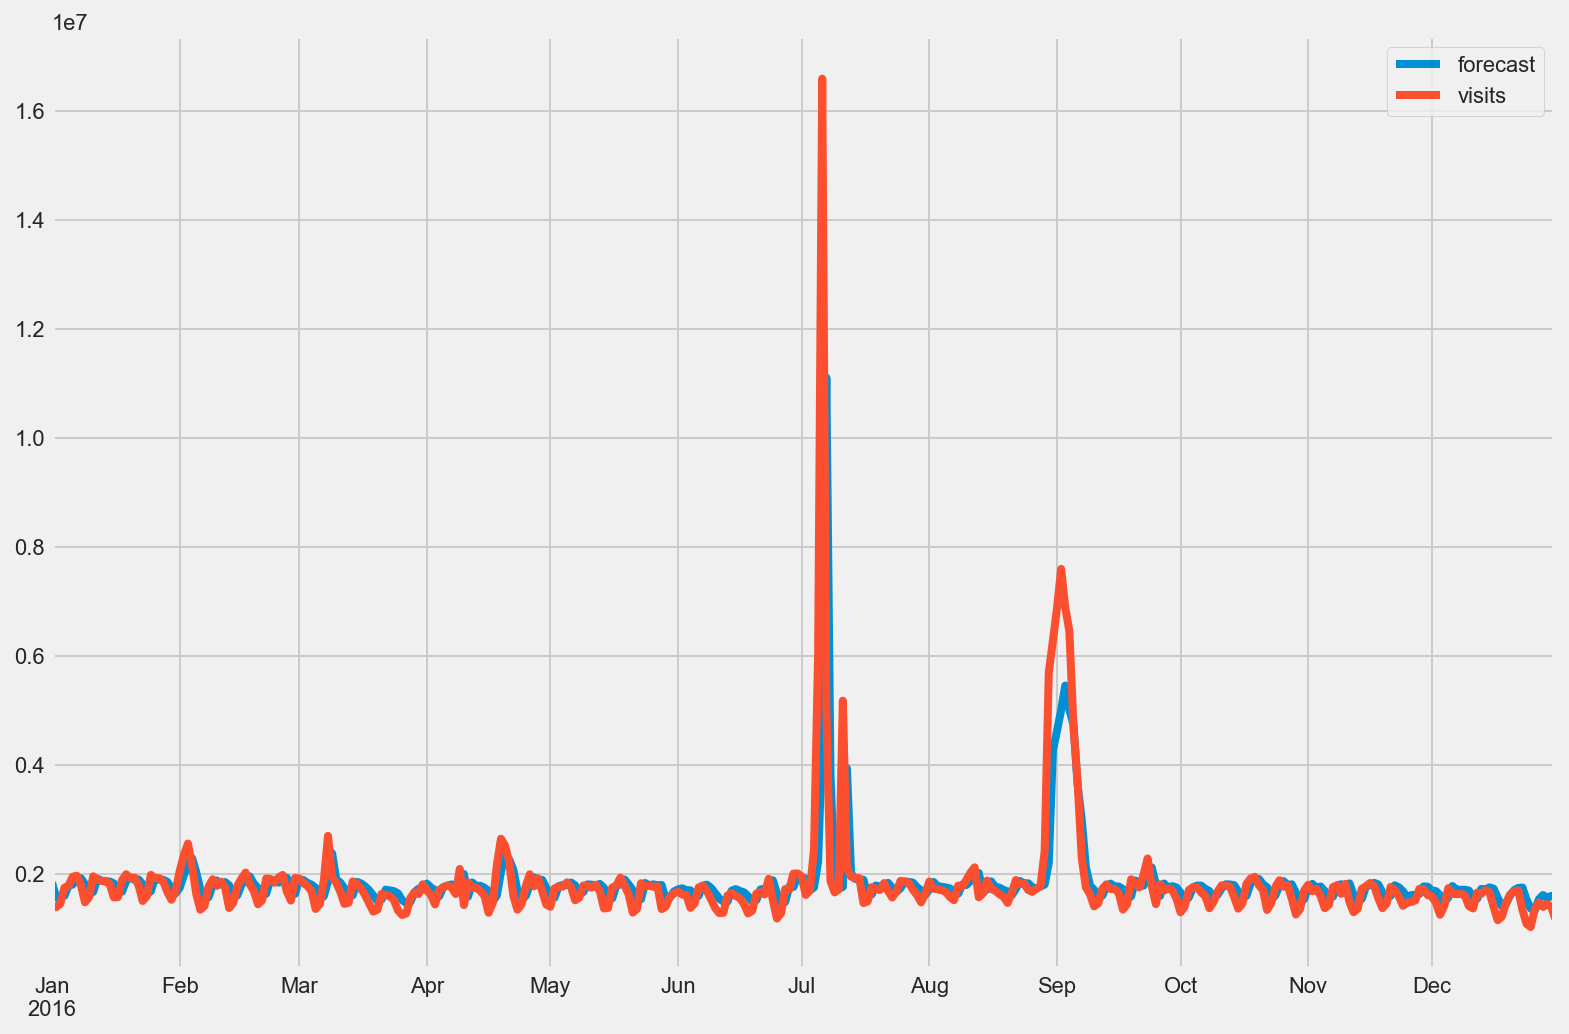

In [41]:
# Actual vs Fitted
results_arima100.plot_predict(dynamic=False)
plt.show()

In [42]:
# Accuracy metrics
def timeseries_evaluation(ytest, ypreds, df_eval=None,show=False,
                          round_=2,index_name=None):
    from statsmodels.tsa.stattools import acf

    if not isinstance(df_eval, pd.DataFrame):
        df_eval = pd.DataFrame({'MAPE': [],
                                'ME': [],
                                'MAE': [],
                                'MPE': [],
                                'RMSE': [],
                                'CORR': [],
                                'MINMAX': [],
                                'ACF1': [],
                                })

    mape = np.mean(np.abs(ypreds - ytest)/np.abs(ytest))  # MAPE
    me = np.mean(ypreds - ytest)             # ME
    mae = np.mean(np.abs(ypreds - ytest))    # MAE
    mpe = np.mean((ypreds - ytest)/ytest)   # MPE
    rmse = np.mean((ypreds - ytest)**2)**.5  # RMSE
    corr = np.corrcoef(ypreds, ytest)[0, 1]   # corr
    mins = np.amin(np.hstack([ypreds[:, None],
                              ytest[:, None]]), axis=1)
    maxs = np.amax(np.hstack([ypreds[:, None],
                              ytest[:, None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax

    acf1 = acf(ypreds-ytest, fft=False)[1]    # ACF1

    row = [mape, me, mae, mpe, rmse, corr, minmax, acf1]

    if index_name:
        df_eval.loc[index_name] =  row
        
    else:
        df_eval.loc[len(df_eval)] = row
    
    df_eval = df_eval.round(round_)
    
    if show:
        display(df_eval)
    return df_eval

In [43]:
# 1,0,0 AR Model
train = ts.iloc[:300]
model = ARIMA(train, order=(1,0,0))
results_arima100 = model.fit(disp=0)

/Users/poudel/opt/miniconda3/envs/gam/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/poudel/opt/miniconda3/envs/gam/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency informa

In [44]:
# Forecast
test =  ts.iloc[300:]
fc, se, conf = results_arima100.forecast(len(test), alpha=0.05)  # 95% conf
timeseries_evaluation(test, fc)

/Users/poudel/opt/miniconda3/envs/gam/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/Users/poudel/opt/miniconda3/envs/gam/lib/python3.7/site-packages/ipykernel_launcher.py:26: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/Users/poudel/opt/miniconda3/envs/gam/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:657: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  FutureWarning,


,MAPE,ME,MAE,MPE,RMSE,CORR,MINMAX,ACF1
0,0.26,372279.08,372279.08,0.26,420198.18,-0.09,0.19,0.53


In [45]:
# https://github.com/statsmodels/statsmodels/blob/master/examples/notebooks/tsa_arma_0.ipynb

arma10 = sm.tsa.ARMA(train, (1,0)).fit(disp=False)
resid = arma10.resid

print(train.shape, resid.shape)
r,q,p = sm.tsa.acf(resid, fft=True, qstat=True)
print(r.shape, q.shape, p.shape)

data = np.c_[range(1,len(r)), r[1:], q, p]

table = pd.DataFrame(data, columns=['lag', "AC", "Q", "Prob(>Q)"])
table.set_index('lag').head()

(300,) (300,)
(41,) (40,) (40,)


/Users/poudel/opt/miniconda3/envs/gam/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/poudel/opt/miniconda3/envs/gam/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency informa

,AC,Q,Prob(>Q)
lag,,,
1.0,0.042116,0.537477,0.463480
2.0,-0.065968,1.860518,0.394452
3.0,-0.028170,2.102592,0.551389
4.0,-0.059243,3.176858,0.528677
5.0,0.206869,16.319903,0.005988


# Auto ARIMA

In [46]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

In [47]:
model = pm.auto_arima(ts, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

model.summary()


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=11092.335, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=11712.531, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=11095.687, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=11475.698, Time=0.02 sec


 ARIMA(2,0,1)(0,0,0)[0]             : AIC=11090.849, Time=0.09 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=11094.755, Time=0.02 sec


 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=0.30 sec


 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.31 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=11064.631, Time=0.07 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=11432.449, Time=0.03 sec


 ARIMA(1,0,3)(0,0,0)[0]             : AIC=11061.297, Time=0.17 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=11397.376, Time=0.05 sec


 ARIMA(2,0,3)(0,0,0)[0]             : AIC=11062.418, Time=0.20 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=11042.894, Time=0.08 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=11050.512, Time=0.06 sec


 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=11040.693, Time=0.07 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=11066.585, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=11040.158, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=11084.832, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=11039.466, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=11221.532, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=11040.000, Time=0.04 sec


 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=11042.104, Time=0.09 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 1.894 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  366
Model:               SARIMAX(1, 0, 0)   Log Likelihood               -5516.733
Date:                Sat, 17 Oct 2020   AIC                          11039.466
Time:                        14:33:23   BIC                          11051.174
Sample:                             0   HQIC                         11044.118
                                - 366                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   6.839e+05   8.28e+04      8.256      0.000    5.22e+05    8.46e+05
ar.L1          0.6284      0.010     60.466      0.000       0.608       0.649
sigma2      7.248e+11      0.690   1.05e+12      0.000    7.25e+11    7.25e+11
===================================================================================
Ljung-Box (L1) (Q):                   0.62   Jarque-Bera (JB):            222704.07
Prob(Q):                              0.43   Prob(JB):                         0.00
Heteroskedasticity (H):               3.28   Skew:                             7.63
Prob(H) (two-sided):                  0.00   Kurtosis:                       122.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number  3e+39. Standard errors may be unstable.
"""

## Interpret the residual plots in ARIMA model

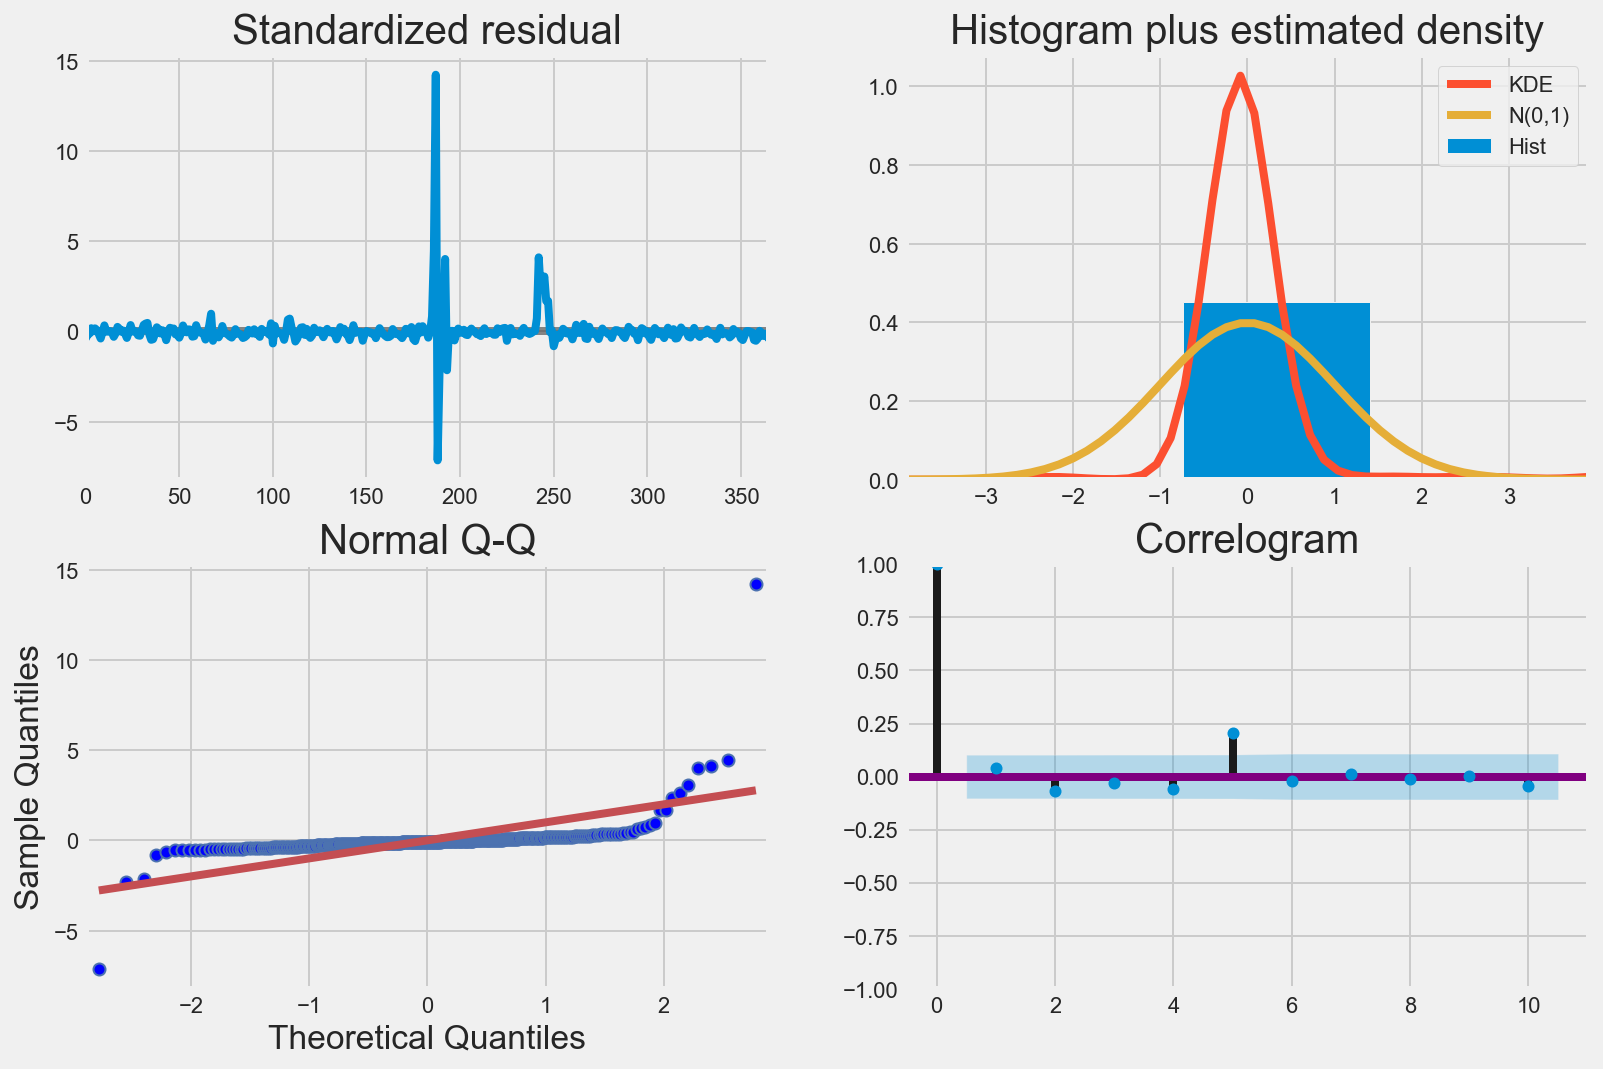

In [48]:
model.plot_diagnostics(figsize=(12,8))
plt.show()

Plot diagnostics:

>  Fig1: The residuals over time (top left plot) don't display any obvious seasonality and appear to be white noise. There are two peaks, but they might be outiers.

> Fig2 : In the top right plot, we see that the red KDE line does NOT follow closely with the normal distribution N(0,1) line. So the residuals are NOT normally distributed. NOT Good.

> Fig3: The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) does NOT follow the linear trend of the samples taken from a standard normal distribution with N(0, 1). Again, this is a strong indication that the residuals are NOT normally distributed.

>  Fig4: (bottom left) This is an autocorrelation (i.e. correlogram) plot of the time series residuals to the lagged versions of itself. This shows there is not much correlation. Almost all of the correlations lies within the significance region. There 
is not much seasonality in the data.

Meaning: Our fitting is not so good.  
Further work: We may want to normalize the data. We may want do deal with outliers.

## Future Predictions

In [49]:
ts.head(2).append(ts.tail())

date
2016-01-01    1401667
2016-01-02    1395136
2016-12-27    1481319
2016-12-28    1399599
2016-12-29    1455447
2016-12-30    1397331
2016-12-31    1175657
Name: visits, dtype: int32

In [50]:
show_methods(results_arima100)

,0,1,2,3
0,aic,fittedvalues,maroots,resid
1,arfreq,forecast,mle_retvals,save
2,arparams,hqic,mle_settings,scale
3,arroots,initialize,model,sigma2
4,bic,k_ar,n_totobs,summary
5,bse,k_constant,nobs,summary2
6,conf_int,k_exog,normalized_cov_params,t_test
7,cov_params,k_ma,params,t_test_pairwise
8,cov_params_default,k_trend,plot_predict,tvalues
9,data,llf,predict,use_t


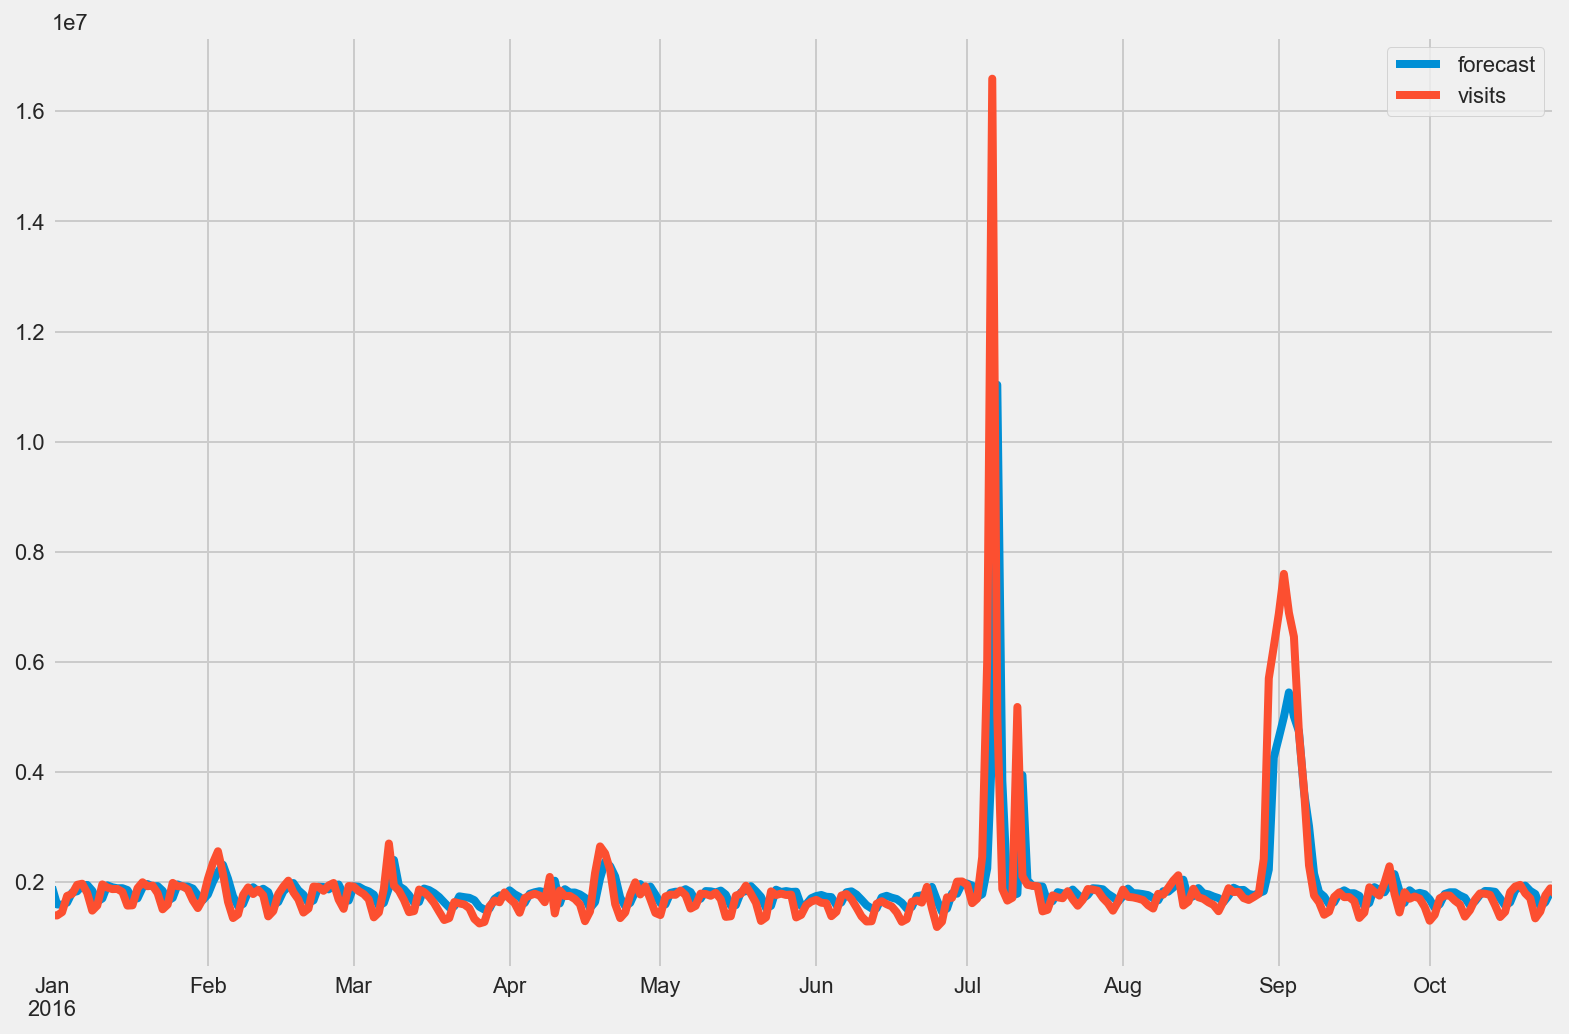

In [51]:
results_arima100.plot_predict(dynamic=False)
plt.show()

# train from data upto dec 1 and forecast the rest data.

# dynamic=False argument ensures that we produce one-step ahead forecasts.
# meaning that forecasts at each point are generated using
# the full history up to that point. 